In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords # to remove stopwords 
nltk.download('stopwords') # for downloading the stopword of english
nltk.download('punkt') #this is required for sentence tokenization
from nltk.stem import PorterStemmer #this for stemming
from nltk.stem import WordNetLemmatizer #this is used in lemmatization
nltk.download('wordnet') # this is required for lemmatization

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import  auc
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [135]:
df_spam = pd.read_csv('/content/drive/My Drive/Spam_ham/SMSSpamCollection',sep='\t',names=['Label','Corpus'])

In [136]:
df_spam.head()

,Label,Corpus
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [137]:
#checking the length of message
df_spam['Length'] = df_spam.Corpus.apply(len)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


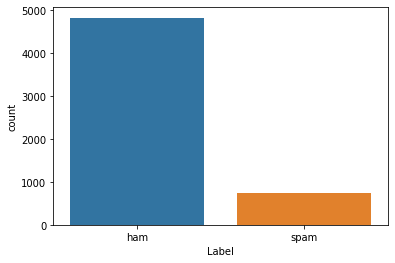

In [138]:
#checkig the distribution of class
sns.countplot(df_spam['Label'])

## Bag-of-words model

Modelling using the stemming techniques

In [139]:
#text cleaning

def clean_text(df,columns,tech):

  corpus = []
  cleaned_corpus= []

  if tech == 'stem':
    ps = PorterStemmer()
    for i in df[columns]:
      clean_sent = re.sub('[^a-zA-Z]',' ', i).lower().split()
      remove_stopwords = [ps.stem(words) for words in clean_sent if words not in set(stopwords.words('english'))]
      corpus.append(' '.join(remove_stopwords))
      cleaned_corpus.append(' '.join(remove_stopwords))
  else:
    lamm = WordNetLemmatizer()
    for i in df[columns]:
      clean_sent = re.sub('[^a-zA-Z]',' ', i).lower().split()
      remove_stopwords = [lamm.lemmatize(words) for words in clean_sent if words not in set(stopwords.words('english'))]
      corpus.append(' '.join(remove_stopwords))
      cleaned_corpus.append(' '.join(remove_stopwords))
  return corpus,cleaned_corpus

In [140]:
def evaluate_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC Curve")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    plt.show()

In [141]:
df_spam['Corpus_clean_stem'],cleaned_corpus = clean_text(df_spam,columns='Corpus',tech='stem') #using stemming

In [142]:
#creating dummies for the target variable
df_spam['Target'] = pd.get_dummies(df_spam['Label'],drop_first=True)

In [143]:
df_spam['Corpus'].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: Corpus, dtype: object

In [144]:
df_spam.head()

,Label,Corpus,Length,Corpus_clean_stem,Target
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri wkli comp win fa cup final tkt st m...,1
3,ham,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,0


In [145]:
def transform_feature(data,tech):

  if tech == 'bow':
    bow = CountVectorizer(max_features=5000)
    x = bow.fit_transform(data).toarray()
  elif tech == 'tfidf':
    tfidf = TfidfVectorizer()
    x = tfidf.fit_transform(data).toarray()
  
  return x

In [146]:
#transforming the feature

x = transform_feature(cleaned_corpus,tech='bow')

In [147]:
#split the data
def split_data(x,y):
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=100)

  return X_train, X_test, y_train, y_test

In [148]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_spam['Target'])

In [149]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4457, 5000), (1115, 5000), (4457,), (1115,))

In [150]:
#train the model
def build_model(X_train,y_train,X_test,y_test):
  
  spam_detect = MultinomialNB()
  spam_detect.fit(X_train,y_train)
  y_pred = spam_detect.predict(X_test)
  predicted_prob = spam_detect.predict_proba(X_test)[:,1]
  evaluate_model(y_test,y_pred, predicted_prob, figsize=(25,5))

Accuracy (overall correct predictions): 0.98
Auc: 0.98
Recall (all 1s predicted right): 0.95
Precision (confidence when predicting a 1): 0.91
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.91      0.95      0.93       147

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



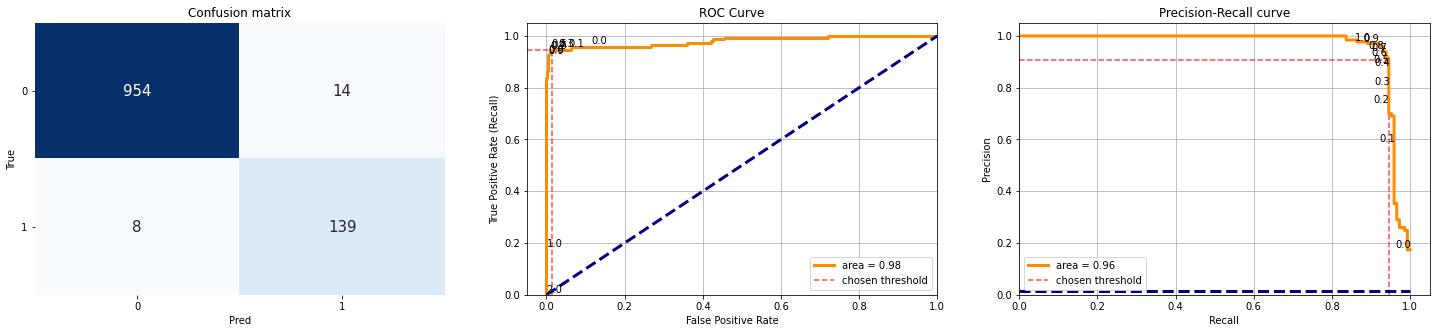

In [151]:
build_model(X_train,y_train,X_test,y_test)

Modelling using Lemmetization techniques

In [125]:
df_spam['Cleaned_corpus_lemma'],cleaned_corpus = clean_text(df_spam,columns='Corpus',tech=' ') #using lemmatization

In [126]:
df_spam.head()

,Label,Corpus,Length,Corpus_clean_stem,Target,Cleaned_corpus_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri wkli comp win fa cup final tkt st m...,1,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,0,nah think go usf life around though


In [127]:
#transforming the feature

x = transform_feature(cleaned_corpus,tech='bow')

In [128]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_spam['Target'])

In [129]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4457, 5000), (1115, 5000), (4457,), (1115,))

Accuracy (overall correct predictions): 0.98
Auc: 0.98
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.91
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.91      0.94      0.93       147

    accuracy                           0.98      1115
   macro avg       0.95      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



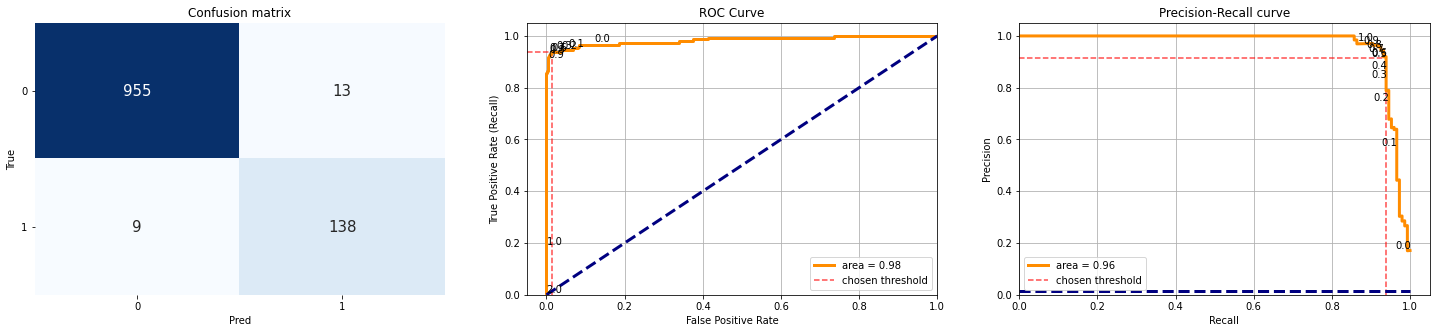

In [130]:
build_model(X_train,y_train,X_test,y_test)

## Modelling using TF-IDF vectorizer

Modelling using the stemming techniques

In [152]:
#transforming the feature

x = transform_feature(cleaned_corpus,tech='tfidf')

In [153]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_spam['Target'])

In [154]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4457, 6296), (1115, 6296), (4457,), (1115,))

Accuracy (overall correct predictions): 0.97
Auc: 0.99
Recall (all 1s predicted right): 0.75
Precision (confidence when predicting a 1): 1.0
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       968
           1       1.00      0.75      0.86       147

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



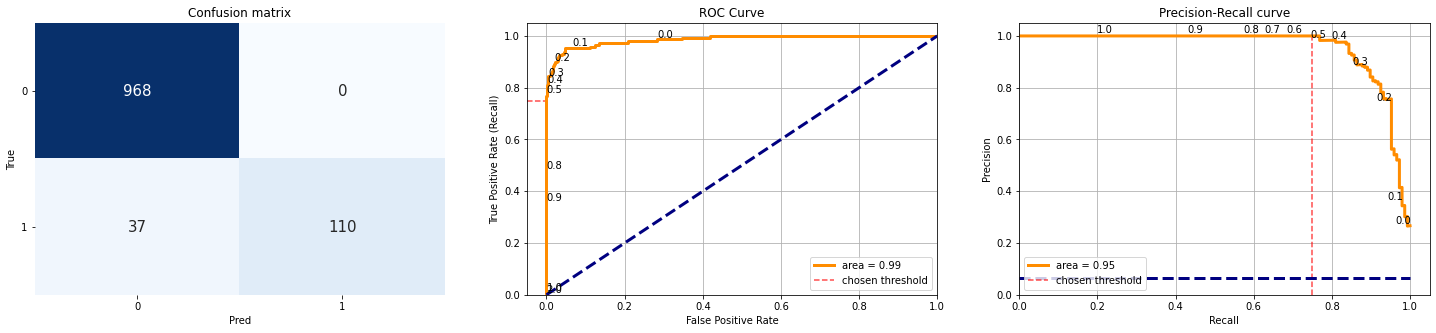

In [155]:
build_model(X_train,y_train,X_test,y_test)

Modelling using the lemmatization techniques

In [131]:
#transforming the feature

x = transform_feature(cleaned_corpus,tech='tfidf')

In [132]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_spam['Target'])

In [133]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4457, 7098), (1115, 7098), (4457,), (1115,))

Accuracy (overall correct predictions): 0.97
Auc: 0.99
Recall (all 1s predicted right): 0.76
Precision (confidence when predicting a 1): 1.0
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       968
           1       1.00      0.76      0.86       147

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



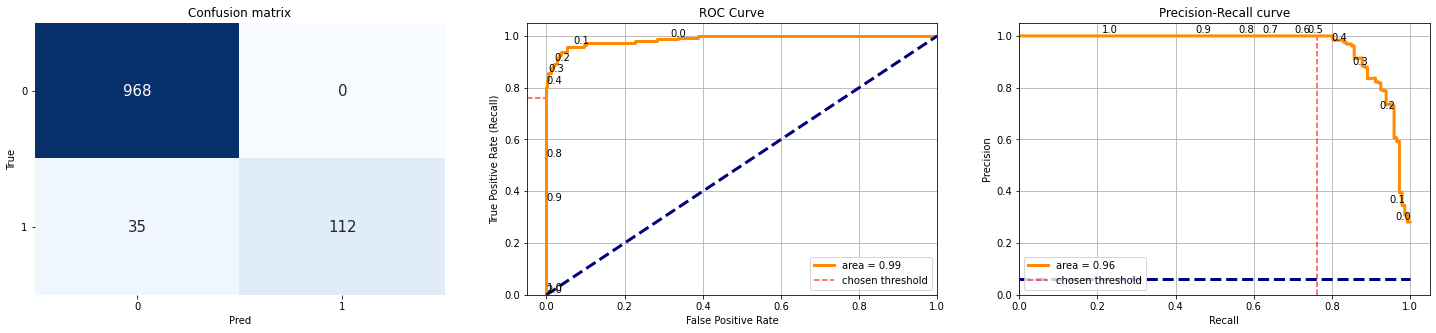

In [134]:
build_model(X_train,y_train,X_test,y_test)